# 랜덤 포레스트를 활용해 Covid-19 발생에 중요한 변수 선택하기 

#### **라이브러리 설치**

In [2]:
! pip install plotly 

  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11435 sha256=e859df40f8dc86ab6ffb00145a7c431c04c2458165f5ebf082926294adee07fd
  Stored in directory: c:\users\jinny\appdata\local\pip\cache\wheels\f9\8d\8d\f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


In [4]:
!pip install cufflinks

  Created wheel for cufflinks: filename=cufflinks-0.17.3-py3-none-any.whl size=68729 sha256=d5b675694d80379b4338970a673a9da43f4cf3370d3a6e330d10649c48a5d3b5
  Stored in directory: c:\users\jinny\appdata\local\pip\cache\wheels\e1\27\13\3fe67fa7ea7be444b831d117220b3b586b872c9acd4df480d0
Successfully built cufflinks


In [5]:
import pandas as pd
import numpy as np
from pandas import DataFrame, Series
from numpy.random import randn
from scipy import stats
import sklearn
from sklearn.datasets import load_boston
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import plotly as pl
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
import cufflinks as cf
cf.go_offline()
import re
import datetime

#### **데이터 불러오기**
1. 오늘의 COVID-19 전세계 분포를 알려주는 데이터 (today’s data on the geographic distribution of COVID-19 cases worldwide) 
- 데이터 출처: European Centre for Disease Prevention and Control(https://www.ecdc.europa.eu/)
- 07/18/2020 까지 업데이트된 자료를 사용

2. 국가별 인구 통계 (면적, 인구, 성비, GDP, 실업률 등) 
- 데이터 출처: UN 데이터를 vinayakbhakta9라는 사람이 전처리한 자료 

In [6]:
# URL로 csv 파일 다운로드 후, Casesdf라는 이름으로 데이터셋 저장하기 
url = "https://opendata.ecdc.europa.eu/covid19/casedistribution/csv"
Casesdf = pd.read_csv(url, encoding='ISO-8859-1') 

Casesdf.tail(2)

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2019,continentExp,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000
30756,22/03/2020,22,3,2020,1,0,Zimbabwe,ZW,ZWE,14645473.0,Africa,NaN
30757,21/03/2020,21,3,2020,1,0,Zimbabwe,ZW,ZWE,14645473.0,Africa,NaN


In [7]:
# 변수명 변경하기 
Casesdf = Casesdf.rename(columns={'countriesAndTerritories': 'Country'})
Casesdf = Casesdf.drop('popData2019', axis=1) 
Casesdf['dateRep'] = pd.to_datetime(Casesdf['dateRep'])

def replaceus(country):
      str = re.sub(r'[\W_]',' ', country)
      return(str)
Casesdf['CountryNew'] = Casesdf['Country'].apply(replaceus)
Casesdf = Casesdf.drop('Country', axis=1)
Casesdf = Casesdf.rename(columns={'CountryNew':'Country'})

In [8]:
url = "https://github.com/vinayakbhakta9/Coronavirus/blob/master/Covid19CasesNew.xlsx?raw=true"
Worlddf = pd.read_excel(url,sheet_name='World')
Worlddf.info()
url = "https://github.com/vinayakbhakta9/Coronavirus/blob/master/WorldPoultry.xlsx?raw=true"
Meetdf = pd.read_excel(url,sheet_name='Sheet1')
Meetdf.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171 entries, 0 to 170
Data columns (total 45 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          171 non-null    object 
 1   Region                           171 non-null    object 
 2   Area                             171 non-null    int64  
 3   Population                       171 non-null    int64  
 4   Population_Density               171 non-null    float64
 5   Sex_Ratio_Mto100F                171 non-null    float64
 6   GDP                              171 non-null    int64  
 7   GDP_Growth_Rate                  171 non-null    float64
 8   GDP_Per_Capita                   171 non-null    float64
 9   Economy_From_Agriculture         171 non-null    float64
 10  Economy_From_Industry            171 non-null    float64
 11  Economy_From_Servicing           171 non-null    float64
 12  Agri_Percent_Employed 

In [9]:
#Calculating Age of the virus in the respective country and rank orders then picks rank 1
CasedfFil = Casesdf[Casesdf['cases']>0]
Cdfgr1 = CasedfFil.groupby('Country')
CasedfFil['Rn'] = Cdfgr1['dateRep'].rank(method='min')
CasedfFil = CasedfFil[CasedfFil['Rn']==1]
#age calculation
def today_date():
    date=datetime.datetime.now().date()
    date=pd.to_datetime(date)
    return date
CasedfFil['Today'] = today_date()
CasedfFil['Diff'] = CasedfFil['Today'] - CasedfFil['dateRep']
#joining with the world df
CasedfFil = CasedfFil[['Country', 'Diff']]
Worlddf = Worlddf.join(CasedfFil.set_index('Country'), on='Country')
Worlddf['Age'] = pd.to_numeric(Worlddf['Diff'].dt.days, downcast='integer')
Worlddf = Worlddf.drop('Diff', axis=1)
#Adding Count of Cases and Count of deaths in Worlf df
Casedfcd = Casesdf.groupby(['Country']).sum()
Casedfcd = Casedfcd.drop(['day','month','year'], axis=1)
Worlddf = Worlddf.join(Casedfcd, on='Country')
#joining with the meet df
Worlddf = Worlddf.join(Meetdf.set_index('Entity'), on='Country')

In [10]:
Worlddf.head()

,Country,Region,Area,Population,Population_Density,Sex_Ratio_Mto100F,GDP,GDP_Growth_Rate,GDP_Per_Capita,Economy_From_Agriculture,...,Age,cases,deaths,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000,Mutton_Consumption,Other_Meat_Consumption,Poultry_Consumption,Pork_Consumption,Beef_Consumption,Total_Meat_Consumption
0,Suriname,SouthAmerica,163820,563,3.6,100.7,4879,-2.7,8985.3,11.4,...,197.0,1001.0,20.0,1822.785420,0.04,0.19,31.06,6.82,4.28,42.39
1,Gabon,MiddleAfrica,267668,2025,7.9,105.6,13735,3.9,7960.7,3.8,...,197.0,6315.0,46.0,3845.983896,0.69,14.85,29.33,7.99,6.34,59.20
2,Seychelles,EasternAfrica,457,95,206.0,97.2,1363,6.8,14133.2,2.7,...,126.0,100.0,0.0,1211.364729,0.44,0.11,2.22,0.25,0.76,3.78
3,Guyana,SouthAmerica,214969,778,4.0,101.9,3282,3.1,4278.8,17.6,...,197.0,327.0,19.0,524.288589,1.10,0.04,38.34,2.37,3.37,45.22
4,Papua New Guinea,Melanesia,462840,8251,18.2,103.5,21315,6.6,2797.6,20.1,...,120.0,15.0,0.0,1.697789,1.79,0.51,4.08,0.17,6.50,13.05


최종적으로 변수 59개가 사용된다. 

#### **결측치 처리**

In [11]:
Worlddf.replace([np.inf, -np.inf], np.nan, inplace=True)
Worlddf.fillna(0, inplace=True) 

#### **랜덤 포레스트 모델 만들기**

##### **1. 사망건수(Deaths) 기준** 

In [55]:
from sklearn.ensemble import RandomForestRegressor

X_train=Worlddf.drop(['Country','Region','cases','deaths'], axis=1)
Y_train=Worlddf['deaths']
Y_train=pd.get_dummies(Y_train)

forest1 = RandomForestRegressor(n_estimators = 100, random_state=1) # 100개의 트리 만들기 
X_train=pd.get_dummies(X_train)

forest1.fit(X_train,Y_train)
features1 = X_train.columns
importances1 = forest1.feature_importances_   # forcast1 모델의 변수 중요도를 importances1에 저장하기 



In [61]:
indices1 = np.argsort(importances1)[-10:] # 변수중요도 top 10을 indices1에 저장하기 

In [50]:
a=np.sort(importances1)
a

array([0.00970469, 0.01189154, 0.0129369 , 0.01308573, 0.01386127,
       0.01395159, 0.01433636, 0.01469468, 0.01511747, 0.01526913,
       0.01558039, 0.01569282, 0.01585745, 0.01599913, 0.01612537,
       0.01663881, 0.01667749, 0.01681055, 0.01685351, 0.01717169,
       0.01741074, 0.01742455, 0.0176801 , 0.01855309, 0.0186212 ,
       0.01874491, 0.01896534, 0.01901417, 0.01917018, 0.01926434,
       0.01941834, 0.01943912, 0.01958887, 0.02015785, 0.02039055,
       0.02059711, 0.02082432, 0.02111258, 0.02154591, 0.02168913,
       0.02252851, 0.02295857, 0.02340135, 0.02380596, 0.02417673,
       0.02505498, 0.02524608, 0.02527095, 0.02910772, 0.03325064,
       0.05732954])

In [62]:
indices1

array([15,  5, 45, 20, 13,  1, 38, 32, 44, 43], dtype=int64)

In [63]:
importances1[indices1]

array([0.02295857, 0.02340135, 0.02380596, 0.02417673, 0.02505498,
       0.02524608, 0.02527095, 0.02910772, 0.03325064, 0.05732954])

#### **변수중요도 그래프 그리기**

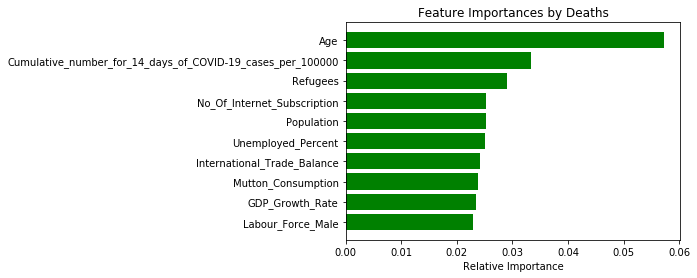

In [64]:
plt.title("Feature Importances by Deaths") 
plt.barh(range(len(indices1)), importances1[indices1], color='g', align='center')  # 가로로 눕혀진 막대그래프 그리기 
plt.yticks(range(len(indices1)), [features1[i] for i in indices1])
plt.xlabel("Relative Importance")
plt.show() 
compdf = pd.DataFrame( {"Column": X_train.columns, "importance": importances1}).sort_values("importance", ascending=False) 

In [65]:
from sklearn.feature_selection import SelectFromModel

sfm1 = SelectFromModel(forest1, threshold=0.05, prefit=True)
X_selected = sfm1.transform(X_train)

print('이 임계 조건을 만족하는 샘플의 수:', X_selected.shape[1])

for f in range(X_selected.shape[1]):
  print("%2d) %-*s %f" % (f + 1, 10,
                          features1[indices1[f]],
                          importances1[indices1[f]])) 

이 임계 조건을 만족하는 샘플의 수: 1
 1) Labour_Force_Male 0.022959


##### **2. 발생건수(Cases) 기준** 

In [39]:
from sklearn.ensemble import RandomForestRegressor

X_train=Worlddf.drop(['Country','Region','cases','deaths'], axis=1)
Y_train2=Worlddf["cases"] # 예측할 변수(y변수)는 발생건수입니다. 데이터셋에는 cases랴는 변수명으로 되어있어요. 
Y_train2=pd.get_dummies(Y_train2)

forest2 = RandomForestRegressor(n_estimators=100, random_state=1)
X_train=pd.get_dummies(X_train)

forest2.fit(X_train,Y_train2)
features2 = X_train.columns
importances2 = forest2.feature_importances_

indices2 = np.argsort(importances2)[-10:]

#### **변수중요도 그래프 그리기**

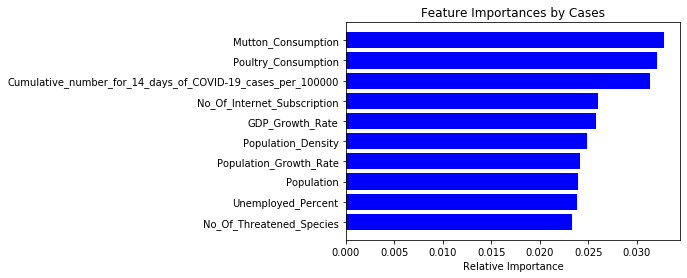

In [40]:
plt.title("Feature Importances by Cases") 
plt.barh(range(len(indices2)), importances2[indices2], color='b', align='center') 
plt.yticks(range(len(indices2)), [features2[i] for i in indices2])
plt.xlabel("Relative Importance")
plt.show() 
compdf = pd.DataFrame( {"Column": X_train.columns, "importance": importances2}).sort_values("importance", ascending=False) 

In [41]:
from sklearn.feature_selection import SelectFromModel

sfm2 = SelectFromModel(forest2, threshold=0.05, prefit=True)
X_selected2 = sfm2.transform(X_train)

print('이 임계 조건을 만족하는 샘플의 수:', X_selected2.shape[1])

for f in range(X_selected2.shape[1]):
  print("%2d) %-*s %f" % (f + 1, 10,
                          features2[indices2[f]],
                          importances2[indices2[f]])) 

이 임계 조건을 만족하는 샘플의 수: 0


C:\Users\jinny\anaconda3\lib\site-packages\sklearn\feature_selection\_base.py:81: UserWarning:

No features were selected: either the data is too noisy or the selection test too strict.

